# Coursera Capstone: Toronto Neighbourhoods and COVID-19

## Introduction

This project will investigate the correlation between COVID-19 cases and the types of venues within neighbourhoods in Toronto. 

This is a topical issue, of pressing concern to the inhabitants of Toronto directly, as well as those living in urban centres around the world.

An understanding of which types of venue pose the greatest risk to people could influence a diverse set of behaviours, such as real estate markets, consumer activity and even governmental social policy with regard to health.

## Data

The data being used for this analysis is drawn from a number of sources:
 - The Toronto postal codes and neighbourhood names from the Canada Postal Service ('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
 - The geocoordinates for each Toronto neighbourhood from Coursera ('http://cocl.us/Geospatial_data')
 - The number of cases per neighbourhood from the City of Toronto website ('https://open.toronto.ca/dataset/covid-19-cases-in-toronto/')
 - The map of Toronto from Folium
 - The information about the venues within each Toronto neighbourhood from Foursquare
    
The venue information for each neighbourhood will be cross-referenced with the number of COVID-19 cases.    
1. Cluster the Toronto neighbourhoods based on venues.
2. Determine average levels of outbreak within each cluster.
2. Compare the venues of each cluster to identify distinguishing features.

## Methodology

### Compiling the neighbourhoods

Importing the necessary libraries.

In [43]:
import pandas as pd
import numpy as np
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

Setting up the dataframe of Toronto neighbourhoods.

In [44]:
toronto_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
# Filtering out unassigned neighbourhoods
is_assigned = toronto_df['Borough'] != 'Not assigned'
toronto_df = toronto_df[is_assigned]

Obtaining the dataframe of geospatial data to merge with the Toronto neighbourhoods.

In [45]:
geo_df = pd.read_csv('http://cocl.us/Geospatial_data')

Merging the geospacial dataframe with the original Toronto neighbourhoods dataframe.

In [46]:
toronto_df = pd.merge(toronto_df, geo_df, on='Postal Code')

In [47]:
toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Establishing the geo-coordinates of the City of Toronto.

In [48]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [49]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


Obtaining the Foursquare venues data.

In [50]:
import json # library to handle JSON files
import requests # library to handle requests

CLIENT_ID = 'V1WIWG54NQREKNL2UJCIOE0VPXXBPPTSTYY1IFS2EUZFDE2H' # your Foursquare ID
CLIENT_SECRET = 'AUDWBF0UI21Z3RWW4UPAN3IBXXOSJ23SIR5DDPFBJQZRJDLG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # Max number of venues returned by Foursquare
radius = 500

Creating a function to pull nearby venues within each neighbourhood.

In [51]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Capturing all of the venues for each neighbourhood in a dataframe.

In [52]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

Applying "One hot encoding" to facilitate analysis.

In [53]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

In [54]:
toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1,"Alderwood, Long Branch",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3,Bayview Village,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
4,"Bedford Park, Lawrence Manor East",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
5,Berczy Park,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.017544,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
6,"Birch Cliff, Cliffside West",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
8,"Business reply mail Processing Centre, South C...",0.055556,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0,0.000000,0.066667,0.066667,0.066667,0.133333,0.133333,0.133333,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


Creating a function to return the most common venues within each neighbourhood.

In [56]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [57]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_df = pd.DataFrame(columns=columns)
venues_df['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    venues_df.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)


In [59]:
venues_df.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Skating Rink,Breakfast Spot,Latin American Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Ethiopian Restaurant,Donut Shop
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Sandwich Place,Dance Studio,Pharmacy,Pub,Gym,Airport Lounge,College Gym,Ethiopian Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Sushi Restaurant,Convenience Store,Deli / Bodega,Supermarket,Middle Eastern Restaurant,Restaurant,Mobile Phone Shop,Pizza Place
3,Bayview Village,Japanese Restaurant,Café,Bank,Chinese Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Restaurant,Coffee Shop,Hobby Shop,Liquor Store,Japanese Restaurant,Indian Restaurant,Pub,Butcher


### Incorporating the COVID-19 data

Creating a dataframe from COVID-19 case data obtained from City of Toronto website.

In [60]:
# The code was removed by Watson Studio for sharing.

In [61]:
covid_df.head()

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
0,30771,1,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No,No,No,No
1,30772,2,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,No,No,No,Yes,No,No
2,30773,3,Sporadic,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No,No,No,No
3,30774,4,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No,No,No,No
4,30775,5,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No,No,No,No


Counting the number of confirmed cases per neighbourhood.

In [62]:
is_confirmed = covid_df['Classification'] == 'CONFIRMED'
confirmed_df = covid_df[is_confirmed]

In [63]:
cases_df = confirmed_df.groupby(['FSA'])['Classification'].count().reset_index()
#cases_df = confirmed_df.rename(columns={'Neighbourhood Name':'Neighborhood','Classification':'Cases'}, inplace=False)
#cases_df = cases_df['Neighborhood','']

In [64]:
cases_df = cases_df.rename(columns={'FSA':'Postal Code','Classification':'Cases'}, inplace=False)

In [65]:
cases_df.head()

,Postal Code,Cases
0,M1B,295
1,M1C,235
2,M1E,427
3,M1G,196
4,M1H,88


Merging the nieghbourhoods with the COVID case data.

In [66]:
cases_df = pd.merge(toronto_df, cases_df, on='Postal Code', how='right')
cases_df.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)


In [67]:
cases_df.set_index('Neighborhood', inplace=True)

In [68]:
cases_df.head()

,Postal Code,Borough,Latitude,Longitude,Cases
Neighborhood,,,,,
Parkwoods,M3A,North York,43.753259,-79.329656,65
Victoria Village,M4A,North York,43.725882,-79.315572,64
"Regent Park, Harbourfront",M5A,Downtown Toronto,43.654260,-79.360636,285
"Lawrence Manor, Lawrence Heights",M6A,North York,43.718518,-79.464763,144
"Islington Avenue, Humber Valley Village",M9A,Etobicoke,43.667856,-79.532242,152


### Clustering neighbourhoods by venue type and calculating average infection rates

In [69]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [70]:
# add clustering labels
venues_df.insert(0, 'Cluster Labels', kmeans.labels_)

In [71]:
venues_df.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Agincourt,Lounge,Skating Rink,Breakfast Spot,Latin American Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Ethiopian Restaurant,Donut Shop
1,1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Sandwich Place,Dance Studio,Pharmacy,Pub,Gym,Airport Lounge,College Gym,Ethiopian Restaurant
2,1,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Sushi Restaurant,Convenience Store,Deli / Bodega,Supermarket,Middle Eastern Restaurant,Restaurant,Mobile Phone Shop,Pizza Place
3,1,Bayview Village,Japanese Restaurant,Café,Bank,Chinese Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
4,1,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Restaurant,Coffee Shop,Hobby Shop,Liquor Store,Japanese Restaurant,Indian Restaurant,Pub,Butcher


In [72]:
venues_cases_df = pd.merge(venues_df, cases_df, how='inner', on='Neighborhood')
venues_cases_df['Cluster Labels'] = venues_cases_df['Cluster Labels'] + 1

In [73]:
clusters = venues_cases_df.groupby(['Cluster Labels'])

Calculate average number of cases per cluster.

In [74]:
clusters = clusters['Cases'].agg(np.mean).astype(int)

In [75]:
clusters.columns=['Cluster Labels','Average Cases']


In [76]:
clusters.head()

Cluster Labels
1     91
2    148
3    138
4    235
5    295
Name: Cases, dtype: int64

### Installing Folium to prepare map of Toronto.

In [34]:
# Installing folium
!conda install -c conda-forge folium=0.5.0 --yes 
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.1               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                       

### Examining each cluster.

#### Cluster 1

In [36]:
venues_cases_df.loc[venues_cases_df['Cluster Labels'] == 1, venues_cases_df.columns[[1] + list(range(2, venues_cases_df.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough,Latitude,Longitude,Cases
9,Caledonia-Fairbanks,Park,Pool,Women's Store,Afghan Restaurant,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,M6E,York,43.689026,-79.453512,159
27,"East Toronto, Broadview North (Old East York)",Park,Convenience Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dance Studio,M4J,East York,43.685347,-79.338106,55
46,Lawrence Park,Park,Swim School,Bus Line,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Event Space,M4N,Central Toronto,43.728020,-79.388790,26
50,"Milliken, Agincourt North, Steeles East, L'Amo...",Park,Asian Restaurant,Playground,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,M1V,Scarborough,43.815252,-79.284577,119
60,Parkwoods,Park,Food & Drink Shop,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Event Space,M3A,North York,43.753259,-79.329656,65
63,Rosedale,Park,Playground,Trail,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Eastern European Restaurant,Dog Run,Curling Ice,M4W,Downtown Toronto,43.679563,-79.377529,31
78,"The Kingsway, Montgomery Road, Old Mill North",Smoke Shop,River,Park,Pool,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center,M8X,Etobicoke,43.653654,-79.506944,38
83,Weston,Park,Convenience Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dance Studio,M9N,York,43.706876,-79.518188,319
89,York Mills West,Park,Convenience Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dance Studio,M2P,North York,43.752758,-79.400049,8


#### Cluster 2

In [37]:
venues_cases_df.loc[venues_cases_df['Cluster Labels'] == 2, venues_cases_df.columns[[1] + list(range(2, venues_cases_df.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough,Latitude,Longitude,Cases
0,Agincourt,Lounge,Skating Rink,Breakfast Spot,Latin American Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Ethiopian Restaurant,Donut Shop,M1S,Scarborough,43.794200,-79.262029,80
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Sandwich Place,Dance Studio,Pharmacy,Pub,Gym,Airport Lounge,College Gym,Ethiopian Restaurant,M8W,Etobicoke,43.602414,-79.543484,69
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Sushi Restaurant,Convenience Store,Deli / Bodega,Supermarket,Middle Eastern Restaurant,Restaurant,Mobile Phone Shop,Pizza Place,M3H,North York,43.754328,-79.442259,199
3,Bayview Village,Japanese Restaurant,Café,Bank,Chinese Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Women's Store,M2K,North York,43.786947,-79.385975,123
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Restaurant,Coffee Shop,Hobby Shop,Liquor Store,Japanese Restaurant,Indian Restaurant,Pub,Butcher,M5M,North York,43.733283,-79.419750,43
5,Berczy Park,Coffee Shop,Bakery,Cocktail Bar,Beer Bar,Farmers Market,Cheese Shop,Seafood Restaurant,Café,Restaurant,Clothing Store,M5E,Downtown Toronto,43.644771,-79.373306,21
6,"Birch Cliff, Cliffside West",General Entertainment,Skating Rink,College Stadium,Café,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,M1N,Scarborough,43.692657,-79.264848,177
7,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Climbing Gym,Burrito Place,Restaurant,Italian Restaurant,Intersection,Stadium,Bar,M6K,West Toronto,43.636847,-79.428191,266
8,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Coffee Shop,Rental Car Location,Boat or Ferry,Sculpture Garden,Airport Gate,Airport Food Court,Airport,M5V,Downtown Toronto,43.628947,-79.394420,141
10,Cedarbrae,Lounge,Gas Station,Bakery,Bank,Athletics & Sports,Caribbean Restaurant,Thai Restaurant,Fried Chicken Joint,Hakka Restaurant,Doner Restaurant,M1H,Scarborough,43.773136,-79.239476,88


#### Cluster 3

In [38]:
venues_cases_df.loc[venues_cases_df['Cluster Labels'] == 3, venues_cases_df.columns[[1] + list(range(2, venues_cases_df.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough,Latitude,Longitude,Cases
38,Humber Summit,Construction & Landscaping,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store,Deli / Bodega,M9L,North York,43.756303,-79.565963,138


#### Cluster 4

In [39]:
venues_cases_df.loc[venues_cases_df['Cluster Labels'] == 5, venues_cases_df.columns[[1] + list(range(2, venues_cases_df.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough,Latitude,Longitude,Cases
49,"Malvern, Rouge",Fast Food Restaurant,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,M1B,Scarborough,43.806686,-79.194353,295


#### Cluster 5

In [78]:
venues_cases_df.loc[venues_cases_df['Cluster Labels'] == 4, venues_cases_df.columns[[1] + list(range(2, venues_cases_df.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough,Latitude,Longitude,Cases
65,"Rouge Hill, Port Union, Highland Creek",Bar,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Farmers Market,M1C,Scarborough,43.784535,-79.160497,235


## Results

### Map showing the Toronto Neighbourhood clusters

In [93]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, width=800, height=500)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
rainbow = ['red','blue','green','yellow','purple']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, case in zip(venues_cases_df['Latitude'], venues_cases_df['Longitude'], venues_cases_df['Neighborhood'], venues_cases_df['Cluster Labels'], venues_cases_df['Cases']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + '  [Cases: ' + str(case) + ']', parse_html=True)
    """
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    """
    folium.Circle(
        [lat, lon],
        radius=case,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


In [94]:
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 550px; bottom: 375px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>Cluster 1</li>
    <li><span style='background:green;opacity:0.7;'></span>Cluster 2</li>
    <li><span style='background:blue;opacity:0.7;'></span>Cluster 3</li>
    <li><span style='background:yellow;opacity:0.7;'></span>Cluster 4</li>
    <li><span style='background:purple;opacity:0.7;'></span>Cluster 5</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

map_clusters.get_root().add_child(macro)

### Graph of the relative average number of COVID-19 cases within each cluster

In [83]:
clusters

Cluster Labels
1     91
2    148
3    138
4    235
5    295
Name: Cases, dtype: int64

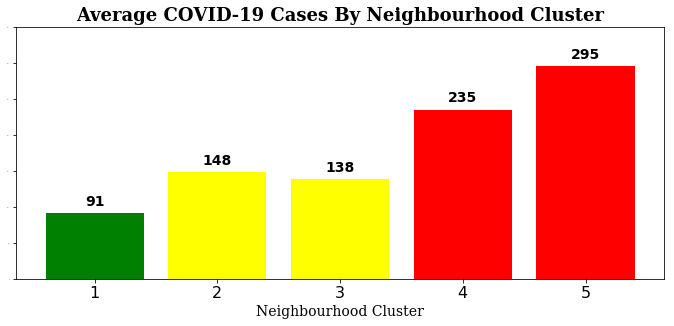

In [98]:
import matplotlib.pyplot as plt

font1 = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 18,
        }

font2 = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }
fig = plt.figure(figsize=(9,3.5))


ax = fig.add_axes([0,0,1,1])
neighbourhood_clusters = ['1','2','3','4','5']
covid_cases = clusters
ax.bar(neighbourhood_clusters,covid_cases, color=['green', 'yellow', 'yellow', 'red', 'red'])
plt.ylim(0,350)

def autolabel(rects, ax):
    for rect in rects:
        x = rect.get_x() + rect.get_width()/2.
        y = rect.get_height()
        ax.annotate("{}".format(y), (x,y), xytext=(0,5), textcoords="offset points",
                    ha='center', va='bottom', fontsize=14, fontweight='bold')

        
autolabel(ax.patches,ax)

plt.xlabel('Neighbourhood Cluster', fontdict=font2)
plt.title('Average COVID-19 Cases By Neighbourhood Cluster', fontdict=font1)

ax.tick_params(axis = 'x', labelsize = 16)
ax.tick_params(axis = 'y', labelsize = 0)
plt.show()

## Discussion

### Describing the neighbourhood clusters

#### Cluster 1
Cluster 1 is distinguished by having a large number of outdoor venues, including parks, dog runs, trails and rivers. In fact, the majority of the neighbourhoods in this cluster have parks as the single most numerous venue type.

#### Cluster 2-3
Cluster 2 is located in the downtown core of the city, where population density is highest. It includes some areas with low-density populations, where businesses such as banks and other corporate offices are closed during the pandemic, as well as a large number of the indoor venues also being closed. Cluster 3 is on the North-Western periphery of Toronto, but is located next to the Humber Valley park, which is a relatively large parkland area.

#### Clusters 4-5
Clusters 4 and 5 are urban residential areas, located on the Eastern periphery of the downtown core. There are almost no parks or other outdoor venues in the top 10 venues listed.

### Observations on COVID-19 cases in the clusters

The clusters group into 3 zones relative to COVID-19:

LOW: Cluster 1's relatively low number of cases may be related to the proliferation of outdoor venues located within the neighbourhoods. This would certainly be in line with public health guidelines on the relative safety of outdoor gatherings, with people maintaining social distance.

MEDIUM: Cluster 2 may have mitigating factors impacting the average number. The fact that the downtown business district is sparsely populated and under lockdown, together with the presence of a moderate number of parks, could be contributing to the case numbers being relatively lower than clusters 4 and 5. Cluster 3, although it is lower than cluster 2, 4 and 5, is still 50% higher in COVID-19 cases than cluster 1. It borders on a single large parkland area, Humber River Park, which may mitigate against a higher number of cases.

HIGH: Clusters 4 and 5 are located on the Eastern periphery of the city in highly residential residential areas with very few outdoor venues. Although they are less densely populated than the other clusters, they have the highest number of cases.   

### Potential for further investigation

Further investigation into the correlation between the nature of the venues and the degree of COVID-19 infection is warranted. 

Potential further analysis includes:

 - Linear regression testing of the number of outdoor venues vs indoor venues
 - Furhter classification of indoor venues based on size and potential traffic, with subsequent linear regression analysis
 - Investigation of the demographic breakdown of residents within the neighbourhoods to see who is most at risk 

## Conclusion

During this pandemic, it is critical to develop social policies that maximize public health. There has been much discussion of designing health policies to address rural vs urban needs. 

This study makes it clear that even at the neighbourhood level there can be significant differences in outcomes. It is strongly suggested from this brief examination that outdoor venues are a key factor in public health and can contribute to the continued health of residents. 